---
# What is the link between bias, variance, overfitting and underfitting?
---

When dealing with a noisy signal, the first step taken is often to smooth it or to fit a model on it. 
In this script, we concentrate on model fitting and use polynomials to do it. The conclusions we draw 
is also be applicable to smoothing. 

During the process of signal fitting with a polynomial, we rapidly notice that some polynomials are better 
than others and the most complex ones are rarely the best ones. Complexity is not always the solution. 
The root of the fitting problem lies in the phenomena known as overfitting and underfitting. This is 
what we investigate in the script.

The mean squared error (MSE) between a fitted signal and the original signal is a very useful tool to study both phenomena. 
It can be expressed as 
<blockquote> $MSE = Bias^{2} + Variance$ </blockquote> <br>
The bias is the difference between the original and the average smoothed signal. 
The variance is a measure of local variability of the smoothed signal. This is explained in the coming sections.


In [1]:
print(__doc__)

# Authors: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: XXX

%matplotlib inline

import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


Automatically created module for IPython interactive environment


# Part I: Show the relationship $MSE = Bias^{2} + Variance$ 

In [2]:
# Define a baseline model (noise-free signal)
def model(x):
    y = np.sin(x)
    return y

# Generate a noisy dataset
def generate_noisy_signal(N):
    x = np.random.uniform(x_min,x_max,N)
    y = model(x) + np.random.normal(0.0, sigma, N)

    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    return x, y

# Function used for regression
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [3]:
# Used for reproductibility
np.random.seed(43)

# Generate the baseline signal over the complete data range
x_min = 0
x_max = 10
xx = np.linspace(x_min,x_max,100)[:,np.newaxis]
yy = model(xx)

# Generate noisy data. 
sigma = 0.2  # Noise level
N = 20
X,y = generate_noisy_signal(N)

Measure MSE, bias and variance for fitting polynomial of various degrees. 

In [4]:
# Baseline data
y_true = model(X)

# For each polynomial degree, n_rep copies of the noisy signal are generated and fitted. 
# The MSE, bias and variance are computed for each fit.
n_rep = 1000
n_degres = 16
degres = range(n_degres)

hx = np.zeros((N,n_rep))
bias2 = np.zeros(n_degres)
variance = np.zeros(n_degres)
mse = np.zeros(n_degres)

for degre in degres:
    ssr = 0
    for n in range(n_rep):
        # Add noise to the baseline signal
        y = y_true + np.random.normal(0.0, sigma, N).reshape(-1,1)
        
        # Get the fitted signal and save it
        y_pred = PolynomialRegression(degre).fit(X, y).predict(X)
        hx[:,n] = np.squeeze(y_pred,axis=1)

        # Compute and accumulate the sum of squared residuals (SSR)
        residuals = y_pred - y_true
        ssr += np.square(residuals).mean()
        
    # Get the average fitted signal
    E_hx = np.mean(hx,1).reshape(-1,1)

    # Compute the bias^2 between the baseline and the average fitted signal
    bias2[degre] = np.square(E_hx-y_true).mean() 
    
    # Compute the variance between each fitted signal and the average fitted signal
    variance[degre] = np.square(E_hx-hx).mean()
    
    # Compute the MSE
    mse[degre] = ssr/n_rep
               

Display the relationship $MSE = Bias^{2} + Variance$ versus the degree of the fitting polynomial.

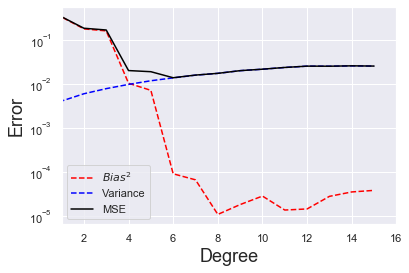

In [5]:
plt.plot(degres, bias2, color='red', label='$Bias^{2}$',linestyle='--')
plt.plot(degres, variance, color='blue', label='Variance',linestyle='--')
plt.plot(degres, mse, color='black', label='MSE')
plt.legend(loc='best')
plt.xlabel('Degree',fontsize=18)
plt.ylabel('Error',fontsize=18)
plt.xlim([1,n_degres])
plt.yscale('log')

plt.savefig('MSE_Bias_Variance', format='png')

# Part II: Show the optimum polynomial degree that minimizes the MSE.

In [6]:
# Find the optimum polynomial degree that minimizes the MSE
indx = np.argmin(mse)
degre_opt = degres[indx]

# Get the best signal estimate over the complete data range
y_pred_opt = PolynomialRegression(degre_opt).fit(X, y).predict(xx)

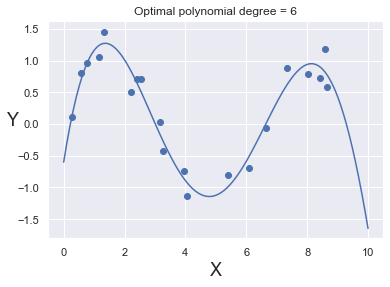

In [7]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
plt.plot(xx, y_pred_opt);
plt.xlabel('X',fontsize=18)
plt.ylabel('Y',rotation=0,fontsize=18)
plt.title('Optimal polynomial degree = %d' % (degre_opt));

plt.savefig('Optimum polynomial fit', format='png')

# Part III: The MSE as a tool to locate the onset of overfitting

In this section, we use noisy datasets for training and testing.
For each polynomial degree, we fit training signals and measure their MSE. Next, we apply the resulting fitting polynomials 
on the testing signals and measure their MSE. Both MSE values behave differently with respect to the polynomial degree.

In [8]:
# Compute the MSE for smoothing polynomials with training and testing data. 
N = 50
n_rep = 1000

mse_train = np.zeros(n_degres)
mse_test = np.zeros(n_degres)

for degre in degres:
    ssr_train, ssr_test = 0,0
    for n in range(n_rep):
        # Generate 2 datasets; one for training and one for testing 
        X_train, y_train = generate_noisy_signal(N)
        X_test, y_test = generate_noisy_signal(N)
        
        # Fit the training data
        reg = PolynomialRegression(degre).fit(X_train, y_train)
            
        # Predict the smoothed signal using training data and get the sum of squared residuals (SSR)
        y_pred = reg.predict(X_train)
        y_true = model(X_train)
        residuals = y_pred - y_true
        ssr_train += np.square(residuals).mean()

        # Predict the smoothed signal using testing data and get the sum of squared residuals
        y_pred = reg.predict(X_test)
        y_true = model(X_test)
        residuals = y_pred - y_true
        ssr_test += np.square(residuals).mean()
        
    # Compute the training and testing MSE
    mse_train[degre] = ssr_train/n_rep
    mse_test[degre] = ssr_test/n_rep

The following figure shows that the training MSE decreases with polynomial degree $d$ and reaches a minimum value 
where it barely changes afterwards. The minimum is found at $d=6$. 

The testing MSE draws a different picture. It reaches a minimum in MSE at $d=6$ but then rapidly increases with 
larger values of $d$.

There is underfitting for polynomials with $d<6$ and overfitting for polynomials with $d>6$ 

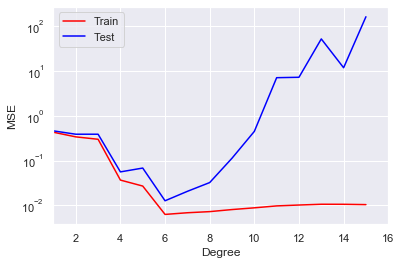

In [9]:
plt.plot(degres, mse_train, color='red', label='Train')
plt.plot(degres, mse_test, color='blue', label='Test')
plt.legend(loc='best')
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.xlim([1,n_degres])
plt.yscale('log')

plt.savefig('MSE varies with polynomial degree', format='png')

# Part IV: The link between bias, variance, overfitting and underfitting

In this section, we show several regression examples with polynomials of a given order. 
The goal is to understand the links between bias and underfitting and between variance and overfitting. 

In [10]:
# Function that displays baseline signal and original data 
def plot_data(ax):
    ax.scatter(X, y, color='black')
    ax.plot(xx,yy);   
    ax.plot([xx.min(), xx.max()],[0, 0], color='black',linestyle='--')
    ax.set_ylim([-1.5, 1.5])
    ax.set_xlabel('X',fontsize=14)
    ax.set_ylabel('Y',rotation=0,fontsize=14)
    ax.set_title('Original data')
    
# Function that displays several fits for a given polynomial degree
def fit_poly(degre,N,ax):
    N = 50
    n_rep = 5
    for n in range(n_rep):
        X, y = generate_noisy_signal(N)
        y_pred = PolynomialRegression(degre).fit(X, y).predict(xx)
        ax.plot(xx,y_pred);   
    
    ax.plot([xx.min(), xx.max()],[0, 0], color='black',linestyle='--')
    ax.set_ylim([-1.5, 1.5])
    ax.set_xlabel('X',fontsize=14)
    ax.set_ylabel('Y',rotation=0,fontsize=14)
    ax.set_title('Polynomial degree = %d' % (degre))
    

In the figure below, the last two fits on the first row are too simple to reproduce the details of the original 
signal; they underfit it. In each case, the average fit is quite different from the baseline and thus has a 
large bias. On the other hand, the fits have a small local variability and thus a small variance. 

The last two fits on the second row are quite complex and contains details not seen in the baseline; they overfit it. 
In each case, the average fit is quite similar to the baseline and has a small bias. However, some wide local
variability is present near the edges; the signal variance is high.

The first fit on the second row is the optimal one; it has low bias and variance.

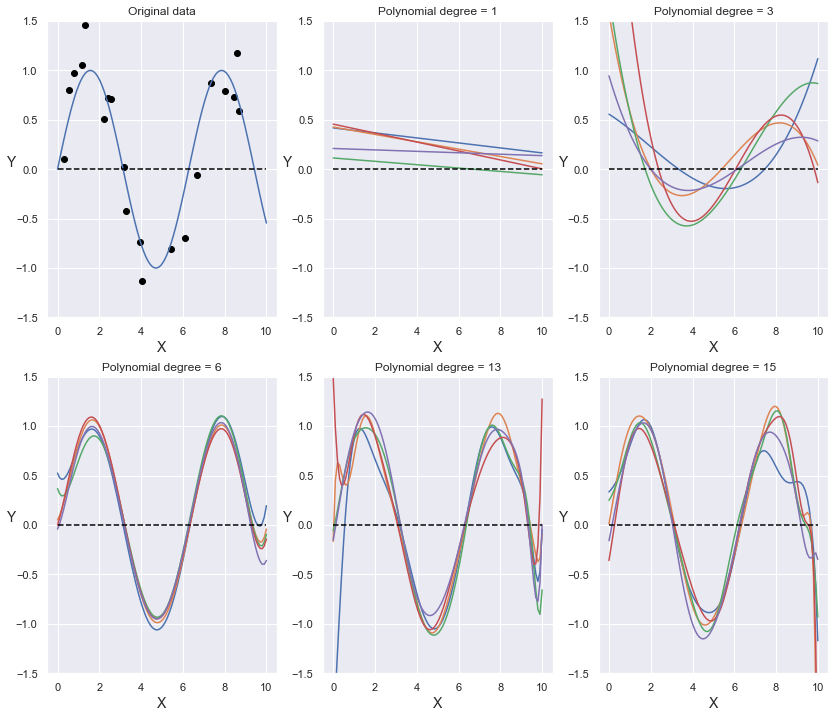

In [11]:
degrees = [1, 3, 6, 13, 15]

fig, axes = plt.subplots(2, 3,figsize=(14, 12))
plot_data(axes[0,0])
fit_poly(degrees[0],N,axes[0,1])
fit_poly(degrees[1],N,axes[0,2])
fit_poly(degrees[2],N,axes[1,0])
fit_poly(degrees[3],N,axes[1,1])
fit_poly(degrees[4],N,axes[1,2])

plt.savefig('Various examples of polynomial fits', format='png')